# Kaggle Titanic Classification Problem

## Introduction

This notebook was created by Johan Hendrik de Jongh (<A Href="https://github.com/de-longhi">de-longhi</A>) and the aim of it is to predict whether a passenger on the titanic will survive or not. The data is from <A Href="https://www.kaggle.com/datasets">Kaggle</A> and I am doing this to try to increase my knowledge about my field. I am only a student so some help will always be appreciated.

## Imports

In [25]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm

from sklearn.tree import ( DecisionTreeClassifier as DTC ,DecisionTreeRegressor as DTR ,plot_tree ,export_text)
from sklearn.metrics import (accuracy_score ,log_loss)
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier as GBC


from sklearn.model_selection import GridSearchCV


AttributeError: module 'numba' has no attribute 'generated_jit'

## Boilerplate

In [2]:
df = pd.read_csv(filepath_or_buffer="../Data/train.csv")
test_df = pd.read_csv(filepath_or_buffer="../Data/test.csv")
X_without_dummies = df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]].dropna(axis = "index")
X = pd.get_dummies(data = X_without_dummies)
Y = df[["Survived"]]

## Data Wrangling

We start by looking at our database. We see that there is a lot of missing data in the Cabin column and some missing data in the Age column. The Ticket and Name columns don't seem very usefull at first but the ticket may point to where on the ship the person was located and the Name column tells us the Title of each person.

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We see that there are two missing values in the "Embarked" column. 

In [5]:
df.corr(numeric_only = True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [6]:
survived_data = df.loc[df["Survived"] == 1, :].dropna(axis = "index", subset = "Age")
not_survived_data = df.loc[df["Survived"] == 0, :].dropna(axis = "index", subset = "Age")

We start with the numerical predictors: Age and Fare. As can be seen from the boxplots, the spread of data between survivors and non-survivors within age is very similar. The spread within Fare is much more significant. We can see that although the medians are similar, a much bigger percentage survivors are higher fare payers than non-survivors.

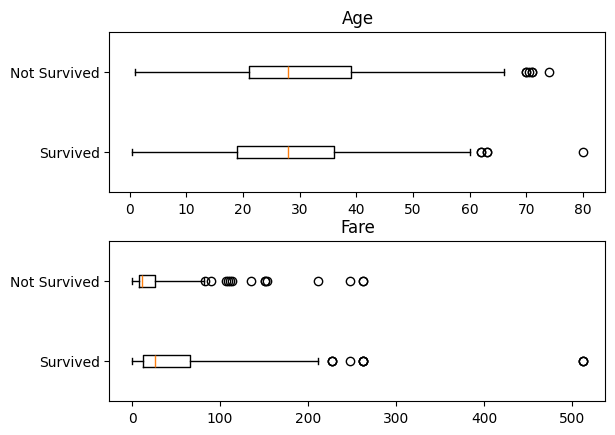

In [7]:
fig_num, axs_num = plt.subplots(2)
plt.subplots_adjust(hspace=0.3)
axs_num[0].boxplot([survived_data.loc[:, "Age"].values, not_survived_data.loc[:, "Age"].values], labels=['Survived', 'Not Survived'], vert = False);
axs_num[0].set_title("Age");
axs_num[1].boxplot([survived_data.loc[:, "Fare"].values, not_survived_data.loc[:, "Fare"].values], labels=['Survived', 'Not Survived'], vert = False, whis = 3);
axs_num[1].set_title("Fare"); # Outlier sensitivity has been decreased to increase visibility

Next, we explore the catergorical predictors namely: Pclass, Sex, SibSp, Parch and Embarked.

NameError: name 'get_pc_rate' is not defined

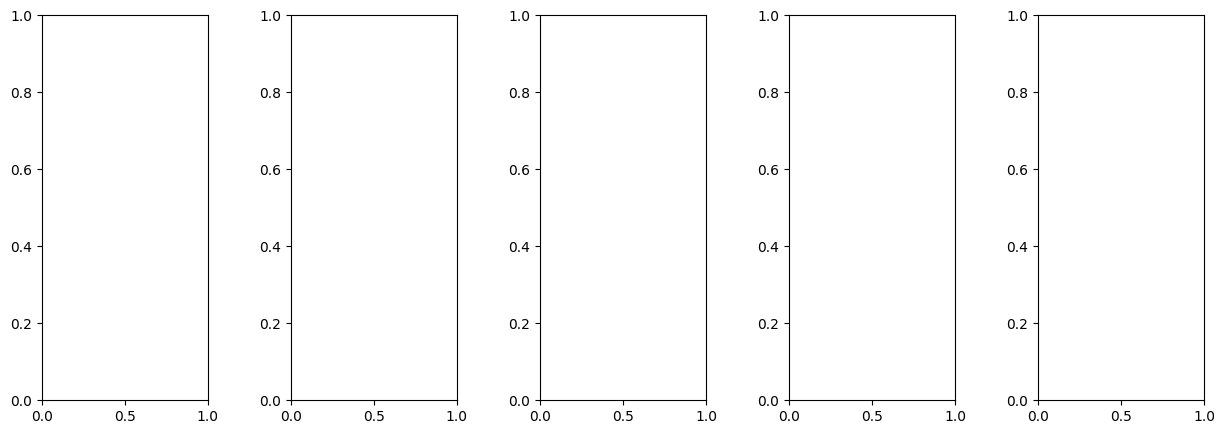

In [8]:
fig_cat, axs_cat = plt.subplots(1, 5, figsize = (15, 5))
plt.subplots_adjust(wspace=0.5)

axs_cat[0].bar(x = [1, 2, 3], height = survived_data.groupby("Pclass")["PassengerId"].count().reset_index(name = "Count").apply(get_pc_rate, axis = 1));
axs_cat[0].set_xlabel("Pclass");
axs_cat[0].set_ylabel("Percentage survived");

axs_cat[1].bar(x = ["female", "male"], height = survived_data.groupby("Sex")["PassengerId"].count().reset_index(name = "Count").apply(get_sex_rate, axis = 1));
axs_cat[1].set_xlabel("Sex");
axs_cat[1].set_ylabel("Percentage survived");

axs_cat[2].bar(x = ["0", "1", "2", "3", "4"], height = survived_data.groupby("SibSp")["PassengerId"].count().reset_index(name = "Count").apply(get_sibling_rate, axis = 1));
axs_cat[2].set_xlabel("Number of siblings");
axs_cat[2].set_ylabel("Percentage survived"); #note: none of 5 siblings on the ship survived and for the sake of simplicity, they are not included.

axs_cat[3].bar(x = ["0", "1", "2", "3", "5"], height = survived_data.groupby("Parch")["PassengerId"].count().reset_index(name = "Count").apply(get_children_rate, axis = 1));
axs_cat[3].set_xlabel("Number of children");
axs_cat[3].set_ylabel("Percentage survived"); #note: all people with 4 or 6 children passed on the Titanic, they are not included.

axs_cat[4].bar(x = ["C", "Q", "S"], height = survived_data.groupby("Embarked")["PassengerId"].count().reset_index(name = "Count").apply(get_embarked_rate, axis = 1));
axs_cat[4].set_xlabel("Port of Embarkation");
axs_cat[4].set_ylabel("Percentage survived"); #note: all people with 4 or 6 children passed on the Titanic, they are not included.

## The Model

The focus of this notebook is primarily for me to practice trees so we start by analysing the data using a basic decision tree. This will also determine the most valuable predictors for our model. Note: Tree based methods are not scale sensitive so we will not be standardizing the data as according to the theory, it will not give us a useful performance increase. We will try every basic tree-based method and use GridSearch to find the best hyperparameters. We don't include Age in the predictors because of Nan values and complications regarding this in test data. Age also doesn't seem to have a lot of predictive power when it comes to survival.

In [ ]:
X_without_dummies = df.loc[:, ["Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked"]]
X = pd.get_dummies(data = X_without_dummies, columns = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]) # Dummy variables in this function are created using one-hot encoding
Y = df.loc[:, "Survived"]

X.insert(20, column = "Parch_9",  value = np.zeros(shape = X.shape[0]))
#X_train, X_val, Y_train, Y_val = skm.train_test_split(X, Y, test_size = 0.2, random_state = 0)

### Basic Classification Tree:

First, we make a classification tree while specifying a max depth. We use grid search to determine the decision tree with the best max depth. Then, we make a DT without specifying a max depth (letting the tree divide untill all data has been split) and then using grid search to determine the best alpha value with regards to pruning. We compare both the estimated test error. Test error is obviously estimated with the use of cross validation, splitting the data into 10 groups.

In [ ]:
#---- Model without pruning ------
basic_model1 = DTC(criterion = "entropy", random_state = 0)
parameters1 = {"max_depth" : [1, 2, 3, 4, 5, 6, 7, 8]}
grid_search1 = GridSearchCV(estimator = basic_model1, param_grid = parameters1, cv = 10, refit = True)

grid_search1.fit(X, Y);
print(grid_search1.best_params_)
print(grid_search1.best_score_)

{'max_depth': 3}
0.8069538077403247


In [ ]:
#---- Model with pruning ----
basic_model2 = DTC(criterion = "entropy", random_state = 0)
ccp_path = basic_model2.cost_complexity_pruning_path (X , Y)
parameters2 = {"ccp_alpha": ccp_path.ccp_alphas}
grid_search2 = GridSearchCV(estimator=basic_model2, param_grid=parameters2, cv=10, refit = True)

grid_search2.fit(X, Y);
print(grid_search2.best_params_)
print(grid_search2.best_score_)

{'ccp_alpha': 0.0009559219894652959}
0.8092384519350813


In [ ]:
X.shape[1]

24

### Model with Bagging or Random Forest

In the previous section, we made a model using a basic decision tree. This model will however suffer from high variance (if we split the data into two parts and fit our model with both parts, we might get completely different trees). We now start with a few ensemble methods that will attempt to aid this problem. We start with Random Forests. Recall that Bagging is simply a special case of Random Forests where all predictors are considered for each subset of the data. We won't try to prune the tree this time because overfitting is already addressed with random feature selection and subset selection.

In [ ]:
forest_model = RF(criterion = "entropy", random_state = 0)
parameters_forest = {"max_depth" : [3, 4, 5, 6, 7, 8], "n_estimators" : [45, 46, 47, 48], "max_features" : [10, 11, 12, 13, 14]}
grid_search_forest = GridSearchCV(estimator = forest_model, param_grid = parameters_forest, cv = 10, refit = True, n_jobs = -1) #run on all threads because this algorithm takes a lot of time
grid_search_forest.fit(X, Y)
print(grid_search_forest.best_params_)
print(grid_search_forest.best_score_)

{'max_depth': 8, 'max_features': 14, 'n_estimators': 46}
0.8193508114856429


### Boosting

We consider one last model in which we use Gradient Boosting. 

In [ ]:
boost_model = GBC(loss = "log_loss",criterion = "squared_error", random_state = 0)
parameters_boost = {"max_depth" : [3, 4, 5, 6, 7, 8], "n_estimators" : [ 50, 51, 52, 53], "max_features" : [10, 11, 12, 13, 14], "learning_rate": [0.1, 0.01, 0.001]}
grid_search_boost = GridSearchCV(estimator = boost_model, param_grid = parameters_boost, cv = 10, refit = True, n_jobs = -1) 
grid_search_boost.fit(X, Y)
print(grid_search_boost.best_params_)
print(grid_search_boost.best_score_)

{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 14, 'n_estimators': 52}
0.82270911360799


## The Final Model

We use the model calculated with the Gradient Boosting algorithm.

In [ ]:
X_test_without_dummies = test_df.loc[:, ["Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked"]]
X_test_without_dummies.Fare = X_test_without_dummies.Fare.fillna(X_test_without_dummies.Fare.mean())
X_test = pd.get_dummies(data = X_test_without_dummies, columns = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"])
predictions = grid_search2.best_estimator_.predict(X_test)
pred_df = pd.DataFrame({"PassengerId": test_df.PassengerId, "Survived" : predictions})
pred_df.to_csv("willi.csv", sep=',', index=False, encoding='utf-8')

In [ ]:
X_test_without_dummies

,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,3,male,0,0,7.8292,Q
1,3,female,1,0,7.0000,S
2,2,male,0,0,9.6875,Q
3,3,male,0,0,8.6625,S
4,3,female,1,1,12.2875,S
...,...,...,...,...,...,...
413,3,male,0,0,8.0500,S
414,1,female,0,0,108.9000,C
415,3,male,0,0,7.2500,S
416,3,male,0,0,8.0500,S


In [ ]:
X_test.columns[X_test.isnull().any()]

Index([], dtype='object')

In [ ]:
X_test.columns

Index(['Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5',
       'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4',
       'Parch_5', 'Parch_6', 'Parch_9', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [ ]:
X.columns

Index(['Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5',
       'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4',
       'Parch_5', 'Parch_6', 'Parch_9', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

## Evaluation

Due to the nature of this competition, we won't do an in depth evaluation. We can see that the random forest performed the best. 

## Functions

In [ ]:
def get_pc_rate(row):
    if row["Pclass"] == 1:
        return row["Count"] / 186 * 100
    if row["Pclass"] == 2:
        return row["Count"] / 173 * 100
    if row["Pclass"] == 3: 
        return row["Count"] / 355 * 100

In [ ]:
def get_sex_rate(row):
    if row["Sex"] == "male":
        return row["Count"] / 261 * 100
    if row["Sex"] == "female":
        return row["Count"] / 453 * 100

In [ ]:
def get_sibling_rate(row):
    if row["SibSp"] == 0:
        return row["Count"] / 471 * 100
    if row["SibSp"] == 1:
        return row["Count"] / 183 * 100
    if row["SibSp"] == 2:
        return row["Count"] / 25 * 100
    if row["SibSp"] == 3:
        return row["Count"] / 12 * 100
    if row["SibSp"] == 4:
        return row["Count"] / 18 * 100
    if row["SibSp"] == 5:
        return row["Count"] / 5 * 100

In [ ]:
def get_children_rate(row):
    if row["Parch"] == 0:
        return row["Count"] / 521 * 100
    if row["Parch"] == 1:
        return row["Count"] / 110 * 100
    if row["Parch"] == 2:
        return row["Count"] / 68 * 100
    if row["Parch"] == 3:
        return row["Count"] / 5 * 100
    if row["Parch"] == 4:
        return row["Count"] / 4 * 100
    if row["Parch"] == 5:
        return row["Count"] / 5 * 100
    if row["Parch"] == 5:
        return row["Count"] / 1 * 100

In [ ]:
def get_embarked_rate(row):
    if row["Embarked"] == "C":
        return row["Count"] / 130 * 100
    if row["Embarked"] == "Q":
        return row["Count"] / 28 * 100
    if row["Embarked"] == "S": 
        return row["Count"] / 554 * 100